# Apply GBDT on Donors Choose dataset

In [1]:
import warnings 
warnings.filterwarnings("ignore") 

import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from scipy.sparse import hstack
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
sns.set()

import pickle
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

from collections import Counter
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\imran\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)
project_data.head(2)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1


In [4]:
project_data.project_is_approved.value_counts()

1    92706
0    16542
Name: project_is_approved, dtype: int64

In [5]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [6]:
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()
project_data['clean_categories']=project_data['project_subject_categories']
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data['clean_categories'].value_counts()

literacy_language                       23655
math_science                            17072
literacy_language_math_science          14636
health_sports                           10177
music_arts                               5180
specialneeds                             4226
literacy_language_specialneeds           3961
appliedlearning                          3771
math_science_literacy_language           2289
appliedlearning_literacy_language        2191
history_civics                           1851
math_science_specialneeds                1840
literacy_language_music_arts             1757
math_science_music_arts                  1642
appliedlearning_specialneeds             1467
history_civics_literacy_language         1421
health_sports_specialneeds               1391
warmth_care_hunger                       1309
math_science_appliedlearning             1220
appliedlearning_math_science             1052
literacy_language_history_civics          809
health_sports_literacy_language   

In [7]:
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,literacy_language


In [8]:
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()
project_data['clean_subcategories']=project_data['project_subject_subcategories']
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data['clean_subcategories'].value_counts()

literacy                                 9486
literacy_mathematics                     8325
literature_writing_mathematics           5923
literacy_literature_writing              5571
mathematics                              5379
                                         ... 
other_warmth_care_hunger                    1
esl_teamsports                              1
literature_writing_nutritioneducation       1
parentinvolvement_warmth_care_hunger        1
esl_economics                               1
Name: clean_subcategories, Length: 401, dtype: int64

In [9]:
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,literacy_language,esl_literacy


In [10]:
project_data['teacher_prefix'].value_counts()

Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

In [11]:
# check if we have any nan values are there
print(project_data['teacher_prefix'].isnull().values.any())
print("number of nan values",project_data['teacher_prefix'].isnull().values.sum())

True
number of nan values 3


In [12]:
project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')

In [13]:
# Remove '.'
# convert all the chars to small
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
project_data['teacher_prefix'].value_counts()

mrs        57272
ms         38955
mr         10648
teacher     2360
dr            13
Name: teacher_prefix, dtype: int64

In [14]:
# We need to get rid of The spaces between the text and the hyphens because they're special characters.
#Rmoving multiple characters from a string in Python
#https://stackoverflow.com/questions/3411771/multiple-character-replace-with-python

project_grade_category = []

for i in range(len(project_data)):
    a = project_data["project_grade_category"][i].replace(" ", "_").replace("-", "_")
    project_grade_category.append(a)

In [15]:
project_data.drop(['project_grade_category'], axis = 1, inplace = True)
project_data["project_grade_category"] = project_grade_category 
print("After removing the special characters ,Column values:  ")
np.unique(project_data["project_grade_category"].values)

After removing the special characters ,Column values:  


array(['Grades_3_5', 'Grades_6_8', 'Grades_9_12', 'Grades_PreK_2'],
      dtype=object)

In [16]:
# convert all of them into small letters
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].value_counts()

ca    15388
tx     7396
ny     7318
fl     6185
nc     5091
il     4350
ga     3963
sc     3936
mi     3161
pa     3109
in     2620
mo     2576
oh     2467
la     2394
ma     2389
wa     2334
ok     2276
nj     2237
az     2147
va     2045
wi     1827
al     1762
ut     1731
tn     1688
ct     1663
md     1514
nv     1367
ms     1323
ky     1304
or     1242
mn     1208
co     1111
ar     1049
id      693
ia      666
ks      634
nm      557
dc      516
hi      507
me      505
wv      503
nh      348
ak      345
de      343
ne      309
sd      300
ri      285
mt      245
nd      143
wy       98
vt       80
Name: school_state, dtype: int64

# Preprocessing Categorical Features:

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# Stopword:

In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

# Preprocessing Categorical Features: essay

In [19]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [20]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [21]:
print("printing some random essay before Preprocessing ")
print(9, project_data['essay'].values[9])
print('-'*50)
print(34, project_data['essay'].values[34])
print('-'*50)
print(147, project_data['essay'].values[147])

printing some random essay before Preprocessing 
9 Over 95% of my students are on free or reduced lunch.  I have a few who are homeless, but despite that, they come to school with an eagerness to learn.  My students are inquisitive eager learners who  embrace the challenge of not having great books and other resources  every day.  Many of them are not afforded the opportunity to engage with these big colorful pages of a book on a regular basis at home and they don't travel to the public library.  \r\nIt is my duty as a teacher to do all I can to provide each student an opportunity to succeed in every aspect of life. \r\nReading is Fundamental! My students will read these books over and over again while boosting their comprehension skills. These books will be used for read alouds, partner reading and for Independent reading. \r\nThey will engage in reading to build their \"Love for Reading\" by reading for pure enjoyment. They will be introduced to some new authors as well as some old f

In [22]:
preprocessed_essays = preprocess_text(project_data['essay'].values)

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [04:39<00:00, 391.05it/s]


In [23]:
print("printing some random essay After preprocessed_essays")
print(9, preprocessed_essays[9])
print('-'*50)
print(34, preprocessed_essays[34])
print('-'*50)
print(147, preprocessed_essays[147])

printing some random essay After preprocessed_essays
9 95 students free reduced lunch homeless despite come school eagerness learn students inquisitive eager learners embrace challenge not great books resources every day many not afforded opportunity engage big colorful pages book regular basis home not travel public library duty teacher provide student opportunity succeed every aspect life reading fundamental students read books boosting comprehension skills books used read alouds partner reading independent reading engage reading build love reading reading pure enjoyment introduced new authors well old favorites want students ready 21st century know pleasure holding good hard back book hand nothing like good book read students soar reading consideration generous funding contribution help build stamina prepare 3rd grade thank much reading proposal nannan
--------------------------------------------------
34 students mainly come extremely low income families majority come homes parents

In [24]:
#creating a new column with the preprocessed essays and replacing it with the original columns
project_data['preprocessed_essays'] = preprocessed_essays
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)

In [25]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

In [26]:
# Sentiment Analysis on 'essay'
sid = SentimentIntensityAnalyzer()
negative_sentiments = []
positive_sentiments = []
neutral_sentiments = []
compound_sentiments = []

In [27]:
for i in tqdm(project_data['preprocessed_essays']):    
    sid_sentiments = sid.polarity_scores(i)
    negative_sentiments.append(sid_sentiments['neg'])
    positive_sentiments.append(sid_sentiments['pos'])
    neutral_sentiments.append(sid_sentiments['neu'])
    compound_sentiments.append(sid_sentiments['compound'])

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [12:53<00:00, 141.29it/s]


In [28]:
# Now append these sentiments columns/freatures to original preprocessed dataframe
project_data['negative_sent'] = negative_sentiments
project_data['positive_sent'] = positive_sentiments
project_data['neutral_sent'] = neutral_sentiments
project_data['compound_sent'] = compound_sentiments

In [30]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,project_grade_category,essay,preprocessed_essays,negative_sent,positive_sent,neutral_sent,compound_sent
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,Educational Support for English Learners at Home,My students need opportunities to practice beg...,0,0,literacy_language,esl_literacy,Grades_PreK_2,My students are English learners that are work...,students english learners working english seco...,0.013,0.154,0.833,0.9694
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,Wanted: Projector for Hungry Learners,My students need a projector to help with view...,7,1,history_civics_health_sports,civics_government_teamsports,Grades_6_8,Our students arrive to our school eager to lea...,students arrive school eager learn polite gene...,0.052,0.305,0.643,0.9856


# Preprocessing Categorical Features: project_title

In [29]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [30]:
print("printing some random reviews Before preprocessed_titles")
print(9, project_data['project_title'].values[9])
print(34, project_data['project_title'].values[34])
print(147, project_data['project_title'].values[147])

printing some random reviews Before preprocessed_titles
9 Just For the Love of Reading--\r\nPure Pleasure
34 \"Have A Ball!!!\"
147 Who needs a Chromebook?\r\nWE DO!!


In [31]:
preprocessed_titles = preprocess_text(project_data['project_title'].values)

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [00:15<00:00, 7232.63it/s]


In [34]:
print("printing some random reviews After preprocessed_titles ")
print(9, preprocessed_titles[9])
print(34, preprocessed_titles[34])
print(147, preprocessed_titles[147])

printing some random reviews After preprocessed_titles 
9 love reading pure pleasure
34 ball
147 needs chromebook


In [32]:
project_data['project_title'].head(2)

0    Educational Support for English Learners at Home
1               Wanted: Projector for Hungry Learners
Name: project_title, dtype: object

In [33]:
#creating a new column with the preprocessed titles,useful for analysis
project_data['preprocessed_titles'] = preprocessed_titles

In [37]:
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,project_grade_category,essay,preprocessed_essays,negative_sent,positive_sent,neutral_sent,compound_sent,preprocessed_titles
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,Educational Support for English Learners at Home,My students need opportunities to practice beg...,0,0,literacy_language,esl_literacy,Grades_PreK_2,My students are English learners that are work...,students english learners working english seco...,0.013,0.154,0.833,0.9694,educational support english learners home


# Merging price with project_data

In [34]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,...,project_grade_category,essay,preprocessed_essays,negative_sent,positive_sent,neutral_sent,compound_sent,preprocessed_titles,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,Educational Support for English Learners at Home,My students need opportunities to practice beg...,0,0,...,Grades_PreK_2,My students are English learners that are work...,students english learners working english seco...,0.013,0.154,0.833,0.9694,educational support english learners home,154.6,23


In [39]:
x=project_data[0:50000]
y = project_data['project_is_approved'][0:50000].values

In [36]:
# train test split using sklearn.model selection
from sklearn.model_selection import train_test_split
# Splitting data into Train and cross validation(or test): Stratifie
X_train, X_test, y_train, y_test = train_test_split(project_data, project_data['project_is_approved'], test_size=0.33, stratify = project_data['project_is_approved'],random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(73196, 22) (73196,)
(36052, 22) (36052,)


In [37]:
print('X_train_shape' , X_train.shape)
print('X_test_shape' , X_test.shape)

X_train_shape (73196, 22)
X_test_shape (36052, 22)


In [40]:
def response_values(feature, df):
    value_count = df[feature].value_counts()
    response_values_dict = dict()
    for i,j in value_count.items():
        vec = []
        for k in range(0,2):
            res_val =len( df.loc[(df['project_is_approved']==k) & (df[feature]==i)])/len( df.loc[(df[feature]==i)])
            vec.append(res_val)
            response_values_dict[i]=vec
    return response_values_dict

In [41]:
def array_response_code(feature, df):
    response_values_dict = response_values(feature, X_train)
    value_count = X_train[feature].value_counts()
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(response_values_dict[row[feature]])
        else:
            gv_fea.append([0.5,0.5])           
    return gv_fea

In [42]:
response_values('clean_categories', X_train)

{'literacy_language': [0.13333333333333333, 0.8666666666666667],
 'math_science': [0.18278168708192163, 0.8172183129180783],
 'literacy_language_math_science': [0.13152486642005753, 0.8684751335799424],
 'health_sports': [0.14745269286754004, 0.85254730713246],
 'music_arts': [0.14436821040594625, 0.8556317895940537],
 'specialneeds': [0.19218695500523195, 0.807813044994768],
 'literacy_language_specialneeds': [0.13979706877113868, 0.8602029312288614],
 'appliedlearning': [0.18113357114546175, 0.8188664288545382],
 'math_science_literacy_language': [0.14285714285714285, 0.8571428571428571],
 'appliedlearning_literacy_language': [0.13370089593383874,
  0.8662991040661613],
 'math_science_specialneeds': [0.1596774193548387, 0.8403225806451613],
 'history_civics': [0.15931372549019607, 0.8406862745098039],
 'math_science_music_arts': [0.16370106761565836, 0.8362989323843416],
 'literacy_language_music_arts': [0.1629162916291629, 0.8370837083708371],
 'appliedlearning_specialneeds': [0.196

In [43]:
X_train_clean_categories_res_code = array_response_code('clean_categories', X_train)
X_test_clean_categories_res_code = array_response_code('clean_categories', X_test)

print("After response coding :")
print(np.shape(X_train_clean_categories_res_code))
print(np.shape(X_test_clean_categories_res_code))

After response coding :
(73196, 2)
(36052, 2)


In [44]:
response_values('clean_subcategories', X_train)

{'literacy': [0.11990595611285267, 0.8800940438871473],
 'literacy_mathematics': [0.12986547085201794, 0.8701345291479821],
 'literature_writing_mathematics': [0.13348706123494747, 0.8665129387650525],
 'mathematics': [0.181267217630854, 0.818732782369146],
 'literacy_literature_writing': [0.1348221670802316, 0.8651778329197684],
 'literature_writing': [0.14271653543307086, 0.8572834645669292],
 'specialneeds': [0.19218695500523195, 0.807813044994768],
 'health_wellness': [0.12334983498349834, 0.8766501650165016],
 'appliedsciences_mathematics': [0.17430406852248395, 0.8256959314775161],
 'appliedsciences': [0.19050480769230768, 0.8094951923076923],
 'literacy_specialneeds': [0.1316747572815534, 0.8683252427184466],
 'gym_fitness_health_wellness': [0.12508185985592665, 0.8749181401440733],
 'esl_literacy': [0.13057961359093936, 0.8694203864090606],
 'visualarts': [0.17890520694259013, 0.8210947930574098],
 'music': [0.1092184368737475, 0.8907815631262525],
 'warmth_care_hunger': [0.079

In [51]:
X_train_clean_subcategories_res_code = array_response_code('clean_subcategories', X_train)
X_test_clean_subcategories_code = array_response_code('clean_subcategories', X_test)

print("After response coding :")
print(np.shape(X_train_clean_subcategories_res_code))
print(np.shape(X_test_clean_subcategories_code))

After response coding :
(73196, 2)
(36052, 2)


In [53]:
response_values('teacher_prefix', X_train)

{'mrs': [0.1448137848584869, 0.8551862151415132],
 'ms': [0.1567528128720095, 0.8432471871279905],
 'mr': [0.15772380683422763, 0.8422761931657724],
 'teacher': [0.19395465994962216, 0.8060453400503779],
 'dr': [0.5, 0.5]}

In [54]:
X_train_teacher_prefix_res_code = array_response_code('teacher_prefix', X_train)
X_test_teacher_prefix_code = array_response_code('teacher_prefix', X_test)

print("After response coding :")
print(np.shape(X_train_teacher_prefix_res_code))
print(np.shape(X_test_teacher_prefix_code))

After response coding :
(73196, 2)
(36052, 2)


In [55]:
response_values('school_state', X_train)

{'ca': [0.13853830349280893, 0.8614616965071911],
 'tx': [0.1874747474747475, 0.8125252525252525],
 'ny': [0.1445978878960195, 0.8554021121039805],
 'fl': [0.16610087293889428, 0.8338991270611057],
 'nc': [0.1430260047281324, 0.8569739952718676],
 'il': [0.14266258086482805, 0.8573374191351719],
 'ga': [0.15867707172054998, 0.84132292827945],
 'sc': [0.13895131086142323, 0.8610486891385768],
 'mi': [0.1626704278326281, 0.8373295721673719],
 'pa': [0.14851001465559355, 0.8514899853444065],
 'in': [0.16280384397964953, 0.8371961560203505],
 'mo': [0.1469248291571754, 0.8530751708428246],
 'oh': [0.12226816302421736, 0.8777318369757826],
 'la': [0.16448598130841122, 0.8355140186915888],
 'ma': [0.13427109974424553, 0.8657289002557544],
 'wa': [0.12572161642078256, 0.8742783835792175],
 'nj': [0.15660252156602522, 0.8433974784339748],
 'ok': [0.1620897521768252, 0.8379102478231748],
 'az': [0.16378714581893572, 0.8362128541810643],
 'va': [0.1464465183058148, 0.8535534816941852],
 'wi': [0

In [56]:
X_train_school_state_res_code = array_response_code('school_state', X_train)
X_test_school_state_code = array_response_code('school_state', X_test)

print("After response coding :")
print(np.shape(X_train_school_state_res_code))
print(np.shape(X_test_school_state_code))

After response coding :
(73196, 2)
(36052, 2)


In [57]:
response_values('project_grade_category', X_train)

{'Grades_PreK_2': [0.1530200887563942, 0.8469799112436058],
 'Grades_3_5': [0.1461873725458835, 0.8538126274541166],
 'Grades_6_8': [0.15360169491525424, 0.8463983050847458],
 'Grades_9_12': [0.15940054495912806, 0.840599455040872]}

In [58]:
X_train_project_grade_category_res_code = array_response_code('project_grade_category', X_train)
X_test_project_grade_category_code = array_response_code('project_grade_category', X_test)

print("After response coding :")
print(np.shape(X_train_project_grade_category_res_code))
print(np.shape(X_test_project_grade_category_code))

After response coding :
(73196, 2)
(36052, 2)


In [59]:
from sklearn.preprocessing import Normalizer
# Our first Numerical feature - 'price'
normalizer = Normalizer()

# As explainEd above first I will reshape(1, -1)
normalizer.fit(X_train['price'].values.reshape(1, -1))

train_normalized_price = normalizer.transform(X_train['price'].values.reshape(1, -1))

test_df_normalized_price = normalizer.transform(X_test['price'].values.reshape(1, -1))

# After normalization reshape again to (-1, 1) i.e. this time unknown rows (i.e. leaving it to Numpy to decide), and specifying I need 1 column
train_normalized_price = train_normalized_price.reshape(-1, 1)


test_df_normalized_price = test_df_normalized_price.reshape(-1, 1)
print(train_normalized_price.shape)
print(test_df_normalized_price.shape)

(73196, 1)
(36052, 1)


In [60]:
### Normalizing next numerical feature: teacher_number_of_previously_posted_projects

# Second Numerical feature - 'teacher_number_of_previously_posted_projects'
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1, -1))

train_normalized_teacher_number_of_previously_posted_projects = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1, -1))

test_df_normalized_teacher_number_of_previously_posted_projects = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1, -1))

# After normalization reshape again to (-1, 1) i.e. this time unknown rows (i.e. leaving it to Numpy to decide), and specifying I need 1 column
train_normalized_teacher_number_of_previously_posted_projects = train_normalized_teacher_number_of_previously_posted_projects.reshape(-1, 1)

test_df_normalized_teacher_number_of_previously_posted_projects = test_df_normalized_teacher_number_of_previously_posted_projects.reshape(-1, 1)
print(train_normalized_teacher_number_of_previously_posted_projects.shape)

print(test_df_normalized_teacher_number_of_previously_posted_projects.shape)

(73196, 1)
(36052, 1)


In [61]:
### Normalizing next numerical feature: negative_sent

# Second Numerical feature - 'negative_sent'
normalizer = Normalizer()

normalizer.fit(X_train['negative_sent'].values.reshape(1, -1))

train_normalized_negative_sent = normalizer.transform(X_train['negative_sent'].values.reshape(1, -1))

test_df_normalized_negative_sent = normalizer.transform(X_test['negative_sent'].values.reshape(1, -1))

# After normalization reshape again to (-1, 1) i.e. this time unknown rows (i.e. leaving it to Numpy to decide), and specifying I need 1 column
train_normalized_negative_sent = train_normalized_negative_sent.reshape(-1, 1)

test_df_normalized_negative_sent = test_df_normalized_negative_sent.reshape(-1, 1)
print(train_normalized_negative_sent.shape)

print(test_df_normalized_negative_sent.shape)

(73196, 1)
(36052, 1)


In [62]:
### Normalizing next numerical feature: negative_sent

# Second Numerical feature - 'positive_sent'
normalizer = Normalizer()

normalizer.fit(X_train['positive_sent'].values.reshape(1, -1))

train_normalized_positive_sent= normalizer.transform(X_train['positive_sent'].values.reshape(1, -1))

test_df_normalized_positive_sent = normalizer.transform(X_test['positive_sent'].values.reshape(1, -1))

# After normalization reshape again to (-1, 1) i.e. this time unknown rows (i.e. leaving it to Numpy to decide), and specifying I need 1 column
train_normalized_positive_sent = train_normalized_positive_sent.reshape(-1, 1)

test_df_normalized_positive_sent = test_df_normalized_positive_sent.reshape(-1, 1)
print(train_normalized_positive_sent.shape)

print(test_df_normalized_positive_sent.shape)

(73196, 1)
(36052, 1)


In [63]:
### Normalizing next numerical feature: negative_sent

# Second Numerical feature - 'neutral_sent'
normalizer = Normalizer()

normalizer.fit(X_train['neutral_sent'].values.reshape(1, -1))

train_normalized_neutral_sent= normalizer.transform(X_train['neutral_sent'].values.reshape(1, -1))

test_df_normalized_neutral_sent = normalizer.transform(X_test['neutral_sent'].values.reshape(1, -1))

# After normalization reshape again to (-1, 1) i.e. this time unknown rows (i.e. leaving it to Numpy to decide), and specifying I need 1 column
train_normalized_neutral_sent = train_normalized_neutral_sent.reshape(-1, 1)

test_df_normalized_neutral_sent = test_df_normalized_neutral_sent.reshape(-1, 1)
print(train_normalized_neutral_sent.shape)

print(test_df_normalized_neutral_sent.shape)

(73196, 1)
(36052, 1)


In [64]:
### Normalizing next numerical feature: negative_sent

# Second Numerical feature - 'compound_sent'
normalizer = Normalizer()

normalizer.fit(X_train['compound_sent'].values.reshape(1, -1))

train_normalized_compound_sent= normalizer.transform(X_train['compound_sent'].values.reshape(1, -1))

test_df_normalized_compound_sent = normalizer.transform(X_test['compound_sent'].values.reshape(1, -1))

# After normalization reshape again to (-1, 1) i.e. this time unknown rows (i.e. leaving it to Numpy to decide), and specifying I need 1 column
train_normalized_compound_sent = train_normalized_compound_sent.reshape(-1, 1)

test_df_normalized_compound_sent = test_df_normalized_compound_sent.reshape(-1, 1)
print(train_normalized_compound_sent.shape)

print(test_df_normalized_compound_sent.shape)

(73196, 1)
(36052, 1)


# TFIDF

In [65]:
## Encoding Essay column using tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_essay_tfidf = TfidfVectorizer(min_df=10)

train_vectorized_tfidf_essay = vectorizer_essay_tfidf.fit_transform(X_train['preprocessed_essays'])

test_df_vectorized_tfidf_essay = vectorizer_essay_tfidf.transform(X_test['preprocessed_essays'])

print(train_vectorized_tfidf_essay.shape)
print(test_df_vectorized_tfidf_essay.shape)

(73196, 14142)
(36052, 14142)


In [66]:
## Encoding preprocessed_titles column using tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_preprocessed_titles_tfidf = TfidfVectorizer(min_df=10)

train_vectorized_tfidf_preprocessed_titles = vectorizer_preprocessed_titles_tfidf.fit_transform(X_train['preprocessed_titles'])

test_df_vectorized_tfidf_preprocessed_titles = vectorizer_preprocessed_titles_tfidf.transform(X_test['preprocessed_titles'])

print(train_vectorized_tfidf_preprocessed_titles.shape)
print(test_df_vectorized_tfidf_preprocessed_titles.shape)

(73196, 2544)
(36052, 2544)


# TFIDF W2V

In [67]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [68]:
# In the TF-IDF Word2Vec vectorization, we have to fit the TfidfVectorizer only on X_train['essay'] and 
# extract 'dictionary' (dictionary with features as the keys and IDF scores as the values) and 
# 'tfidf_words' (a set of all the features extracted from the vectorizer). 
# We have to use the same 'dictionary' and 'tfidf_words' in vectorizing both X_train['essay'] and X_test['essay'].

# Now, at the very top section of this Notebook, we alrady have this code of Vectorizer on X_train data
# vectorizer_essay_tfidf = TfidfVectorizer(min_df=10)
# vectorizer_essay_tfidf.fit(X_train['essay'].values)

# Hence we are now converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(vectorizer_essay_tfidf.get_feature_names(), list(vectorizer_essay_tfidf.idf_)))
tfidf_words = set(vectorizer_essay_tfidf.get_feature_names())

In [69]:
# Function to generate Word2Vec weighted by tf-idf
def generate_w2v_from_text(essays_text_arr):
  # compute average word2vec for each review.
    tfidf_w2v_vectors = []
    # the avg-w2v for each sentence/review is stored in this list

    for sentence in tqdm(essays_text_arr):  # for each sentence
        vector = np.zeros(300)  # as word vectors are of zero length
        tf_idf_weight = 0
        # num of words with a valid vector in the sentence
        for word in sentence.split():  # for each word in a sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word]  # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word] * (
                    sentence.count(word) / len(sentence.split())
                )  # getting the tfidf value for each word
                vector += vec * tf_idf  # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors
  
X_train_vectorized_tfidf_w2v_essay = generate_w2v_from_text(X_train['preprocessed_essays'].values)
X_test_vectorized_tfidf_w2v_essay = generate_w2v_from_text(X_test['preprocessed_essays'].values)

100%|████████████████████████████████████████████████████████████████████████████| 36052/36052 [06:04<00:00, 98.98it/s]


In [68]:
len(X_train_vectorized_tfidf_w2v_essay[0])

300

In [69]:
len(X_test_vectorized_tfidf_w2v_essay[0])

300

In [70]:
# In the TF-IDF Word2Vec vectorization, we have to fit the TfidfVectorizer only on X_train['title'] and 
# extract 'dictionary' (dictionary with features as the keys and IDF scores as the values) and 
# 'tfidf_words' (a set of all the features extracted from the vectorizer). 
# We have to use the same 'dictionary' and 'tfidf_words' in vectorizing both X_train['title'] and X_test['title'].

# Now, at the very top section of this Notebook, we alrady have this code of Vectorizer on X_train data
# vectorizer_preprocessed_titles_tfidf = TfidfVectorizer(min_df=10)
# vectorizer_preprocessed_titles_tfidf.fit(X_train['title'].values)

# Hence we are now converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(vectorizer_preprocessed_titles_tfidf.get_feature_names(), list(vectorizer_preprocessed_titles_tfidf.idf_)))
tfidf_words = set(vectorizer_preprocessed_titles_tfidf.get_feature_names())

In [71]:
# Function to generate Word2Vec weighted by tf-idf
def generate_w2v_from_text(title_text_arr):
  # compute average word2vec for each review.
    tfidf_w2v_vectors = []
    # the avg-w2v for each sentence/review is stored in this list

    for sentence in tqdm(title_text_arr):  # for each sentence
        vector = np.zeros(300)  # as word vectors are of zero length
        tf_idf_weight = 0
        # num of words with a valid vector in the sentence
        for word in sentence.split():  # for each word in a sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word]  # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word] * (
                    sentence.count(word) / len(sentence.split())
                )  # getting the tfidf value for each word
                vector += vec * tf_idf  # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors
  
X_train_vectorized_tfidf_w2v_title = generate_w2v_from_text(X_train['preprocessed_titles'].values)
X_test_vectorized_tfidf_w2v_title = generate_w2v_from_text(X_test['preprocessed_titles'].values)

100%|██████████████████████████████████████████████████████████████████████████| 36052/36052 [00:06<00:00, 5445.73it/s]


In [181]:
len(X_test_vectorized_tfidf_w2v_title[0])

300

In [182]:
len(X_train_vectorized_tfidf_w2v_title[0])

300

# Merging all categorical, text, numerical vectors,preprocessed Title,Preprocessed Essay and sentiment score based on TFIDF

In [128]:
from scipy.sparse import hstack
X_train_hstacked_all_tfidf_features_vectorized = hstack((X_train_clean_categories_res_code,X_train_clean_subcategories_res_code,X_train_teacher_prefix_res_code,X_train_project_grade_category_res_code, X_train_school_state_res_code, train_normalized_price, train_normalized_teacher_number_of_previously_posted_projects,train_vectorized_tfidf_essay,train_vectorized_tfidf_preprocessed_titles,train_normalized_negative_sent,train_normalized_positive_sent,train_normalized_neutral_sent,train_normalized_compound_sent))

print('X_train_hstacked_all_tfidf_features_vectorized.shape is ', X_train_hstacked_all_tfidf_features_vectorized.shape)

test_df_hstacked_all_tfidf_features_vectorized =  hstack((X_test_clean_categories_res_code,X_test_clean_subcategories_code,X_test_teacher_prefix_code,X_test_project_grade_category_code, X_test_school_state_code, test_df_normalized_price, test_df_normalized_teacher_number_of_previously_posted_projects,test_df_vectorized_tfidf_essay,test_df_vectorized_tfidf_preprocessed_titles,test_df_normalized_negative_sent,test_df_normalized_positive_sent,test_df_normalized_neutral_sent,test_df_normalized_compound_sent))

print('test_df_hstacked_all_tfidf_features_vectorized.shape is ', test_df_hstacked_all_tfidf_features_vectorized.shape)

X_train_hstacked_all_tfidf_features_vectorized.shape is  (73196, 16702)
test_df_hstacked_all_tfidf_features_vectorized.shape is  (36052, 16702)


# Applying GBDT Classifier on TFIDF(Set1):
**Set 1: categorical by response coding, numerical features + preprocessed_eassay (TFIDF)+preprocessed_title (TFIDF)+Sentiment scores(preprocessed_essay)**

In [129]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import seaborn as sea

In [130]:
Gb=XGBClassifier(random_state=42,eval_metric='mlogloss')
n_estimators = [5, 10, 50, 100]
depth = [2, 3, 4, 5]
params = {'n_estimators':n_estimators, 'max_depth': depth}
clf = GridSearchCV(Gb, params, cv=3, scoring='roc_auc',verbose=1,return_train_score=True,n_jobs=-1)
clf.fit(X_train_hstacked_all_tfidf_features_vectorized, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 58.5min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=N

In [131]:
print(clf.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [132]:
max_depth = [2, 3, 4, 5]
n_estimators = [5, 10, 50, 100]
    
def get_auc_matrix(x_train, x_test, y_train, y_test ):    

    train_auc_final_arr, test_auc_final_arr = [], []

    for depth in tqdm(max_depth):
        train_auc_batch, test_auc_batch = [], []
        
        for num in n_estimators:
            # Below gives large number of warnings 
            # xgb_clf = XGBClassifier(n_estimators=num, eta=l_rate, reg_alpha=0, reg_lambda=0, tree_method='gpu_hist')
            
            # below works after including eval_metric='mlogloss'
            # xgb_clf = XGBClassifier(n_estimators=num, eval_metric='mlogloss', learning_rate=l_rate, reg_alpha=0, reg_lambda=0, tree_method='gpu_hist')
            
            xgb_clf = XGBClassifier(n_estimators=num, eval_metric='mlogloss',max_depth=depth , reg_alpha=0, reg_lambda=0)
            
            xgb_clf.fit(x_train, y_train)

            # I have to predict probabilities (clf.predict_proba) instead of classes for calculating of ROC AUC score:
            y_train_predicted = xgb_clf.predict_proba(x_train)[:, 1]
            y_test_predicted = xgb_clf.predict_proba(x_test)[:, 1]

            train_auc = roc_auc_score(y_train, y_train_predicted)
            test_auc = roc_auc_score(y_test, y_test_predicted)

            train_auc_batch.append(train_auc)
            test_auc_batch.append(test_auc)
        
        train_auc_final_arr.append(train_auc_batch)
        test_auc_final_arr.append(test_auc_batch)

    return train_auc_final_arr, test_auc_final_arr


train_auc_final_arr_s1, test_auc_final_arr_s1 = get_auc_matrix(X_train_hstacked_all_tfidf_features_vectorized, test_df_hstacked_all_tfidf_features_vectorized , y_train, y_test)


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [31:45<00:00, 476.38s/it]


**plot the performance of model both on train data and cross validation data for each hyper parameter**

- seaborn heat maps with rows as max_depth, columns as n_estimators, and values inside the cell representing AUC Score.

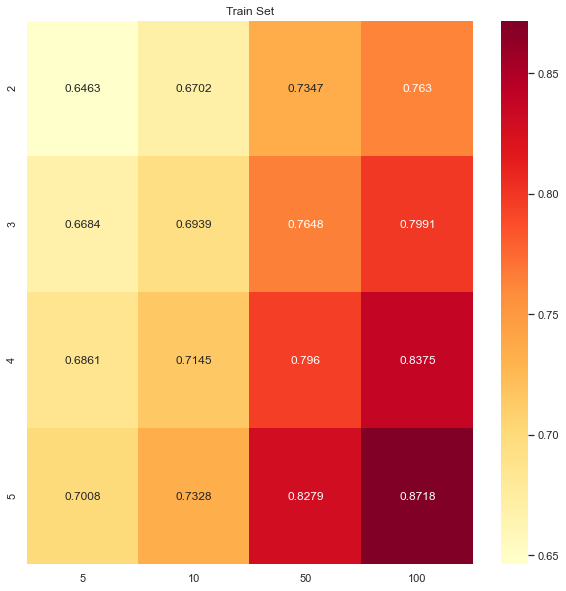

In [133]:
## Heatmap for Set S1

train_auc_final_df_s1 = pd.DataFrame(train_auc_final_arr_s1,columns=n_estimators, index=max_depth)
fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(train_auc_final_df_s1, annot=True, fmt='.4g', ax=ax,cmap="YlOrRd")
ax.set_title('Train Set')
plt.show()
# train_auc_final_df_s1

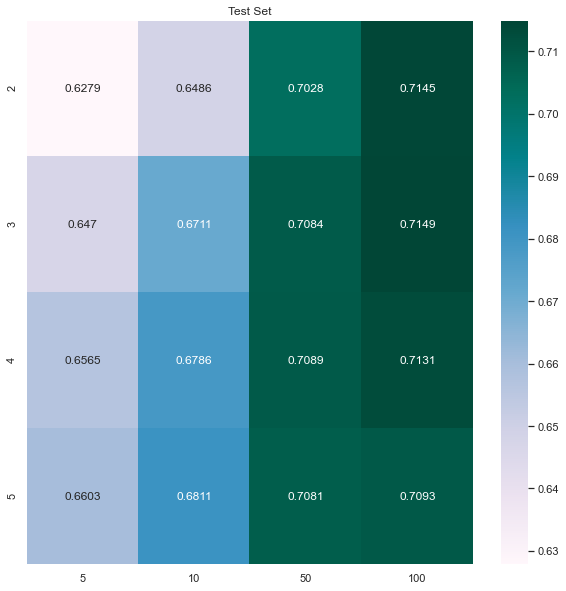

In [134]:
## Heatmap for Set S1

test_auc_final_df_s1 = pd.DataFrame(test_auc_final_arr_s1,columns=n_estimators, index=max_depth)
fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(test_auc_final_df_s1, annot=True, fmt='.4g', ax=ax,cmap="PuBuGn")
ax.set_title('Test Set')
plt.show()
# test_auc_final_df_s1

**plot the ROC curve on both train and test**

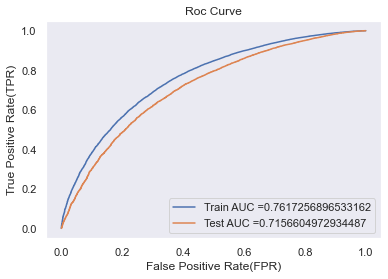

In [135]:
#https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
xgb_tfidf_Model = XGBClassifier(eval_metric='mlogloss',n_estimators=100,max_depth=2)
xgb_tfidf_Model.fit(X_train_hstacked_all_tfidf_features_vectorized, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
# y_train_pred = batch_predict(mnb_bow_testModel, x_train_onehot_bow)
y_train_pred=xgb_tfidf_Model.predict_proba(X_train_hstacked_all_tfidf_features_vectorized)[:,1]
predictions_train_set1=xgb_tfidf_Model.predict(X_train_hstacked_all_tfidf_features_vectorized)

y_test_pred=xgb_tfidf_Model.predict_proba(test_df_hstacked_all_tfidf_features_vectorized)[:,1]
predictions_test_set1=xgb_tfidf_Model.predict(test_df_hstacked_all_tfidf_features_vectorized)


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Roc Curve")
plt.grid()
plt.show()

**Confusion Matrix**

In [136]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    global predictions1
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1 = predictions
    return predictions

the maximum value of tpr*(1-fpr) 0.4838547738648873 for threshold 0.846
the maximum value of tpr*(1-fpr) 0.43712825364814983 for threshold 0.839


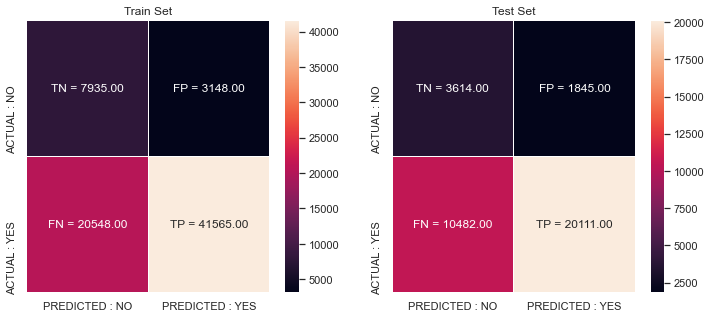

In [137]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()

con_m_train = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
con_m_test = confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')

plt.show()

# Merging all categorical, text, numerical vectors,preprocessed Title,Preprocessed Essay based on TFIDF_W2V:

In [72]:
from scipy.sparse import coo_matrix
X_train_essay_w2v=coo_matrix(X_train_vectorized_tfidf_w2v_essay)
print(X_train_essay_w2v.shape)

(73196, 300)


In [73]:
from scipy.sparse import coo_matrix
X_test_essay_w2v=coo_matrix(X_test_vectorized_tfidf_w2v_essay)
print(X_test_essay_w2v.shape)

(36052, 300)


In [74]:
from scipy.sparse import hstack
X_train_hstacked_all_tfidf_w2v_features_vectorized = hstack((X_train_clean_categories_res_code,X_train_clean_subcategories_res_code,X_train_teacher_prefix_res_code,X_train_project_grade_category_res_code, X_train_school_state_res_code, train_normalized_price, train_normalized_teacher_number_of_previously_posted_projects,X_train_essay_w2v,X_train_vectorized_tfidf_w2v_title))

print('X_train_hstacked_all_tfidf_w2v_features_vectorized.shape is ', X_train_hstacked_all_tfidf_w2v_features_vectorized.shape)

test_df_hstacked_all_tfidf_w2v_features_vectorized =  hstack((X_test_clean_categories_res_code,X_test_clean_subcategories_code,X_test_teacher_prefix_code,X_test_project_grade_category_code, X_test_school_state_code, test_df_normalized_price, test_df_normalized_teacher_number_of_previously_posted_projects,X_test_essay_w2v,X_test_vectorized_tfidf_w2v_title))

print('test_df_hstacked_all_tfidf_w2v_features_vectorized.shape is ', test_df_hstacked_all_tfidf_w2v_features_vectorized.shape)

X_train_hstacked_all_tfidf_w2v_features_vectorized.shape is  (73196, 612)
test_df_hstacked_all_tfidf_w2v_features_vectorized.shape is  (36052, 612)


# Apply GBDT Classifier(XGB Classifier) on these feature sets
**Set 2: categorical by response code, numerical features + preprocessed_essay (TFIDF W2V) + preprocessed_title (TFIDF W2V)**

In [75]:
Gb=XGBClassifier(random_state=42,eval_metric='mlogloss')
n_estimators = [5, 10, 50, 100]
depth = [2, 3, 4, 5]
params = {'n_estimators':n_estimators, 'max_depth': depth}
classifier = GridSearchCV(Gb, params, cv=3, scoring='roc_auc',verbose=1,return_train_score=True,n_jobs=-1)
classifier.fit(X_train_hstacked_all_tfidf_w2v_features_vectorized, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 275.5min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=N

In [76]:
print(classifier.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)


In [75]:
max_depth = [2, 3, 4, 5]
n_estimators = [5, 10, 50, 100]
    
def get_auc_matrix(x_train, x_test, y_train, y_test ):    

    train_auc_final_arr, test_auc_final_arr = [], []

    for depth in tqdm(max_depth):
        train_auc_batch, test_auc_batch = [], []
        
        for num in n_estimators:
            # Below gives large number of warnings 
            # xgb_clf = XGBClassifier(n_estimators=num, eta=l_rate, reg_alpha=0, reg_lambda=0, tree_method='gpu_hist')
            
            # below works after including eval_metric='mlogloss'
            # xgb_clf = XGBClassifier(n_estimators=num, eval_metric='mlogloss', learning_rate=l_rate, reg_alpha=0, reg_lambda=0, tree_method='gpu_hist')
            
            # Only changing the name of the parameter learning_rate to eta
            xgb_clf = XGBClassifier(n_estimators=num, eval_metric='mlogloss',max_depth=depth , reg_alpha=0, reg_lambda=0)
            
            xgb_clf.fit(x_train, y_train)

            # I have to predict probabilities (clf.predict_proba) instead of classes for calculating of ROC AUC score:
            y_train_predicted = xgb_clf.predict_proba(x_train)[:, 1]
            y_test_predicted = xgb_clf.predict_proba(x_test)[:, 1]

            train_auc = roc_auc_score(y_train, y_train_predicted)
            test_auc = roc_auc_score(y_test, y_test_predicted)

            train_auc_batch.append(train_auc)
            test_auc_batch.append(test_auc)
        
        train_auc_final_arr.append(train_auc_batch)
        test_auc_final_arr.append(test_auc_batch)

    return train_auc_final_arr, test_auc_final_arr


train_auc_final_arr_s2, test_auc_final_arr_s2 = get_auc_matrix(X_train_hstacked_all_tfidf_w2v_features_vectorized, test_df_hstacked_all_tfidf_w2v_features_vectorized , y_train, y_test)


100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [1:58:59<00:00, 1784.98s/it]


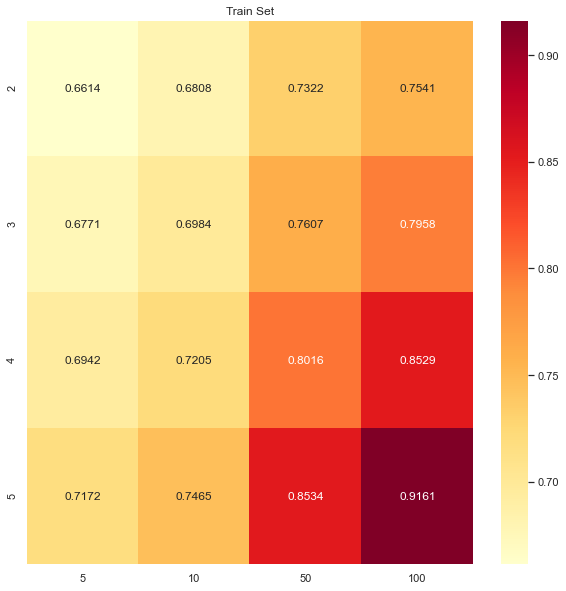

In [76]:
## Heatmap for Set S2

train_auc_final_df_s2 = pd.DataFrame(train_auc_final_arr_s2,columns=n_estimators, index=max_depth)
fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(train_auc_final_df_s2, annot=True, fmt='.4g', ax=ax,cmap="YlOrRd")
ax.set_title('Train Set')
plt.show()
# train_auc_final_df_s2

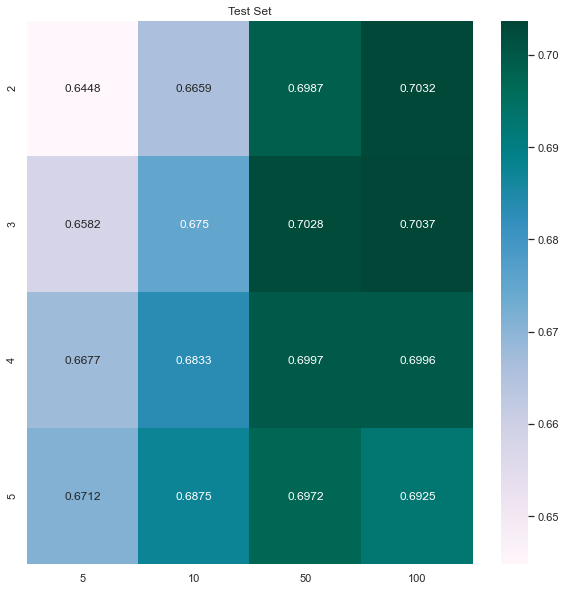

In [77]:
## Heatmap for Set S2

test_auc_final_df_s2 = pd.DataFrame(test_auc_final_arr_s2,columns=n_estimators, index=max_depth)
fig, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(test_auc_final_df_s2, annot=True, fmt='.4g', ax=ax,cmap="PuBuGn")
ax.set_title('Test Set')
plt.show()
# test_auc_final_df_s2

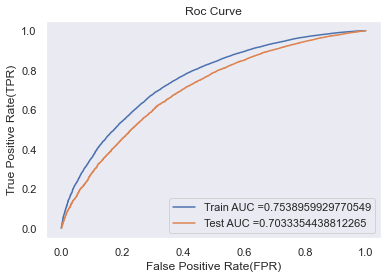

In [78]:
#https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
xgb_tfidf_w2v_Model = XGBClassifier(eval_metric='mlogloss',n_estimators=100,max_depth=2)
xgb_tfidf_w2v_Model.fit(X_train_hstacked_all_tfidf_w2v_features_vectorized, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
# y_train_pred = batch_predict(mnb_bow_testModel, x_train_onehot_bow)
y_train_pred=xgb_tfidf_w2v_Model.predict_proba(X_train_hstacked_all_tfidf_w2v_features_vectorized)[:,1]
predictions_train_set1=xgb_tfidf_w2v_Model.predict(X_train_hstacked_all_tfidf_w2v_features_vectorized)

y_test_pred=xgb_tfidf_w2v_Model.predict_proba(test_df_hstacked_all_tfidf_w2v_features_vectorized)[:,1]
predictions_test_set1=xgb_tfidf_w2v_Model.predict(test_df_hstacked_all_tfidf_w2v_features_vectorized)


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Roc Curve")
plt.grid()
plt.show()

In [79]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    global predictions1
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions1 = predictions
    return predictions

the maximum value of tpr*(1-fpr) 0.47637898345486945 for threshold 0.854
the maximum value of tpr*(1-fpr) 0.4262495541584087 for threshold 0.843


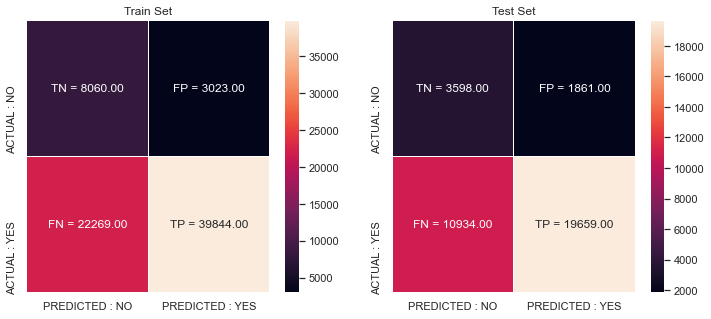

In [80]:
#https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn
import seaborn as sns; sns.set()

con_m_train = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
con_m_test = confusion_matrix(y_test, predict(y_test_pred, te_thresholds, test_fpr, test_tpr))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'], yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])

ax[0].set_title('Train Set')
ax[1].set_title('Test Set')

plt.show()

# Conclusion:

In [81]:
# Please compare all your models using Prettytable library
#how to use pretty table http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= (" Vectorizer ", " Max_depth ", "n_estimators"," Test -AUC ")
tb.add_row([" Tf - Idf", 2 , 100 , 71.56 ])
tb.add_row(["Tf_idf W2v", 2 , 100 ,70.33])
print(tb.get_string(titles = "GBDT- Observations"))

+--------------+-------------+--------------+-------------+
|  Vectorizer  |  Max_depth  | n_estimators |  Test -AUC  |
+--------------+-------------+--------------+-------------+
|   Tf - Idf   |      2      |     100      |    71.56    |
|  Tf_idf W2v  |      2      |     100      |    70.33    |
+--------------+-------------+--------------+-------------+


Refernce:
    
- https://colab.research.google.com/drive/170sML9x7Edz3vpCJAvbWy81_DUABhJvr
- https://github.com/FaisalRasheed99/Applying-Random-Forest-and-XGBoost-on-Donors-Choose-Dataset/blob/master/9_DonorsChoose_RF_GBDT-Solution.ipynb